In [2]:
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

import theano_time_corex
import linearcorex

from sklearn.datasets import make_spd_matrix
import sklearn.covariance as skcov

import random
from scipy.stats import multivariate_normal

# Generate Data

In [55]:
""" Generates random covariance matrix with `nb` independent blocks
"""
def generate_covariance(n, nb=2):
    sizes=[]
    for i in range(n%nb):
        sizes.append(n//nb+1)
    for i in range(nb-n%nb):
        sizes.append(n//nb)
    assert sum(sizes) == n
    pref = 0
    ret = np.zeros((n, n))
    for s in sizes:
        ret[pref:pref+s, pref:pref+s] = make_spd_matrix(s)
        pref += s
    return ret

`nt` - number of timesteps  
`nv` - number of variables (`p` in the paper)  
`nb` - number of block in the covariance matrix  

For each timestep we generate `ns` samples. For the half of timesteps we use one covariance matrix and for the second half we use another sigma (`sigma1`, `sigma2`).  

`X` - the training set
`Y` - the testing set on which we report negative log-likelihood for our estimate of covariance

In [43]:
nt = 10
nv = 128
nb = 128 / 128
myu = np.zeros((nv,))
sigma1 = generate_covariance(nv,nb)
sigma2 = generate_covariance(nv,nb)

# normalize the covariances
for i in range(nv):
    for j in range(nv):
        if (i != j):
            sigma1[i][j] /= np.sqrt(sigma1[i][i]) * np.sqrt(sigma1[j][j])
            sigma2[i][j] /= np.sqrt(sigma2[i][i]) * np.sqrt(sigma2[j][j])

for i in range(nv):
    sigma1[i][i] = 1.0
    sigma2[i][i] = 1.0

"""
order = range(nv)
random.shuffle(order)
tmp = np.zeros(sigma2.shape)
for i in range(nv):
    for j in range(nv):
        tmp[i][j] = sigma2[order[i], order[j]]
sigma2 = tmp
"""

gt = [sigma1] * (nt // 2)
gt += [sigma2] * (nt // 2)

X = []
for i in range(nt):  
    ns = 5
    X.append(np.random.multivariate_normal(myu, gt[i], size=(ns,)))
    
Y = []
for i in range(nt):  
    ns = 256
    Y.append(np.random.multivariate_normal(myu, gt[i], size=(ns,)))

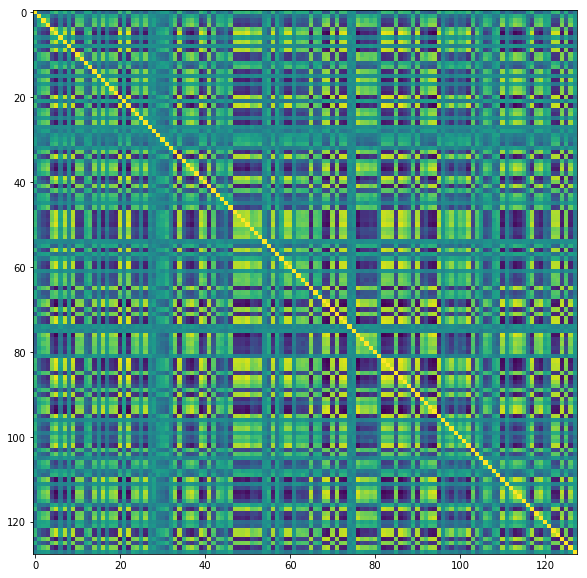

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(sigma1)
plt.show()

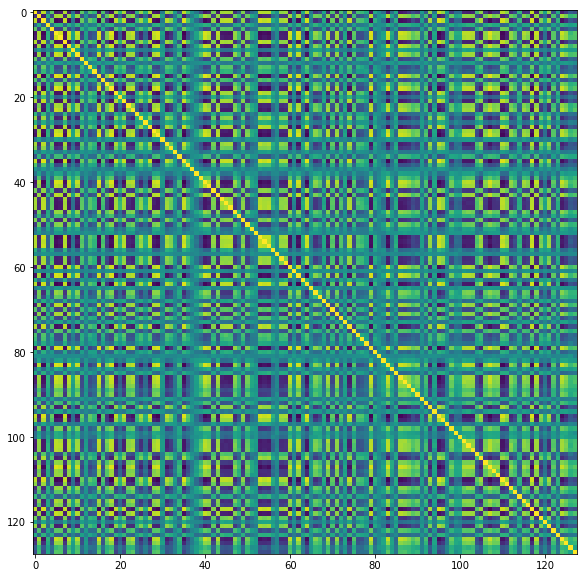

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(sigma2)
plt.show()

#### This graph shows how well the covariance at timestep t models the test data at timestep t+1. Clearly we should see a peak at the middle timestep.

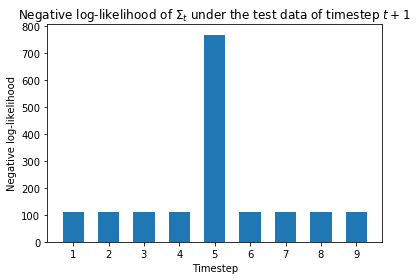

NLL = 182.996014196


In [46]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=gt[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.bar(range(1, nt), nll, width=0.6)
plt.title("Negative log-likelihood of $\Sigma_t$ under the test data of timestep $t + 1$")
plt.xlabel("Timestep")
plt.ylim(0)
plt.ylabel("Negative log-likelihood")
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of ground truth on each timestep. We report the sum of negative log-likelihood over timesteps.

In [47]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=gt[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 109.763858352


# Learn independent linear corexes on each timestep

In [48]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=8*2,
                    max_iter=400,
                    anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

2365.40970993


In [49]:
cs_covs = [c.get_covariance() for c in cs]

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. We would like to see a peak at the middle timestep, but as we don't have many training samples there is no clear peak. We can say that the model overfits a lot at each timestep.

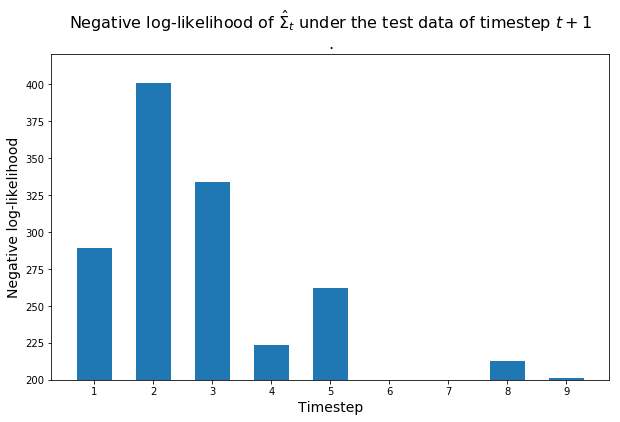

NLL = 256.968562525


In [50]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=cs_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.figure(figsize=(10, 6))
plt.bar(range(1, nt), nll, width=0.6)
plt.title("Negative log-likelihood of $\hat{\Sigma}_t$ under the test data of timestep $t + 1$\n.", fontsize=16)
plt.xlabel("Timestep", fontsize=14)
plt.ylim(200)
plt.ylabel("Negative log-likelihood", fontsize=14)
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [51]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=cs_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 267.801369092


# L1 regularization on the difference of neighbouring covariance estimates

In [21]:
best_nll = np.inf
best_csig = None
best_l1 = None
for l1 in [0.1, 3]:#[0, 0.001, 0.01, 0.1, 0.3, 1, 3, 10, 100]:
    print "training with l1 = {}".format(l1)
    csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                            nv=nv,
                                            n_hidden=8*2,
                                            max_iter=400,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l1 = l1

print "best l1 = {}".format(best_l1)
csig = best_csig
print sum(csig.tc)

training with l1 = 0.1
Annealing iteration finished, time = 50.0493798256
Annealing iteration finished, time = 48.8752338886
Annealing iteration finished, time = 46.0392069817
Annealing iteration finished, time = 49.2871658802
Annealing iteration finished, time = 48.512652874
Annealing iteration finished, time = 47.3649101257
Annealing iteration finished, time = 51.2116041183
training with l1 = 3
Annealing iteration finished, time = 50.3368189335
Annealing iteration finished, time = 48.8012070656
Annealing iteration finished, time = 47.8532500267
Annealing iteration finished, time = 49.2953588963
Annealing iteration finished, time = 46.6989908218
Annealing iteration finished, time = 49.8154900074
Annealing iteration finished, time = 48.3422150612
best l1 = 3
1525.42136991


In [22]:
csig_covs = csig.get_covariance()

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. As we regularize the model we have less overfitting and the system is able to find the change at the middle.

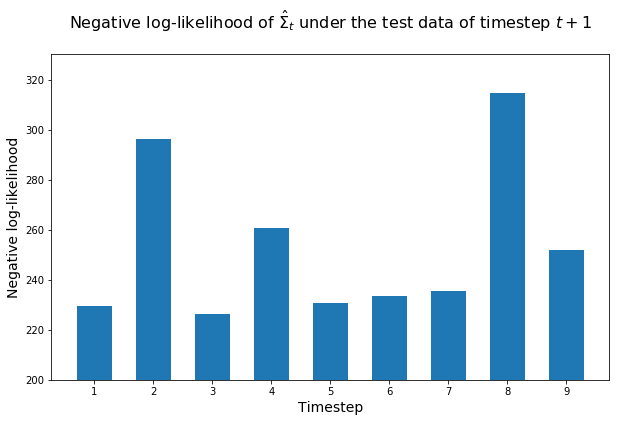

NLL = 253.173870773


In [23]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.figure(figsize=(10, 6))
plt.bar(range(1, nt), nll, width=0.6)
plt.ylim(200)
plt.title("Negative log-likelihood of $\hat{\Sigma}_t$ under the test data of timestep $t + 1$\n", fontsize=16)
plt.xlabel("Timestep", fontsize=14)
plt.ylabel("Negative log-likelihood", fontsize=14)
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [24]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 248.097301516


# L2 regularization on the difference of neighbouring covariance estimates

In [562]:
best_nll = np.inf
best_csig = None
best_l2 = None
for l2 in [0.3, 1, 3]:#[0, 0.001, 0.01, 0.1, 0.3, 1, 3, 10, 100]:
    print "training with l2 = {}".format(l2)
    csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                            nv=nv,
                                            n_hidden=8*2,
                                            max_iter=400,
                                            verbose=False,
                                            anneal=True,
                                            l2=l2)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l2 = l2

print "best l2 = {}".format(best_l2)
csig = best_csig
print sum(csig.tc)

training with l2 = 0.3
Annealing iteration finished, time = 3.18065285683
Annealing iteration finished, time = 3.14979195595
Annealing iteration finished, time = 3.15757799149
Annealing iteration finished, time = 3.14755892754
Annealing iteration finished, time = 3.15683412552
Annealing iteration finished, time = 3.14549517632
Annealing iteration finished, time = 3.15320205688
training with l2 = 1
Annealing iteration finished, time = 3.1510219574
Annealing iteration finished, time = 3.14236187935
Annealing iteration finished, time = 3.13812613487
Annealing iteration finished, time = 3.12658500671
Annealing iteration finished, time = 3.13631105423
Annealing iteration finished, time = 3.13024091721
Annealing iteration finished, time = 3.13005900383
training with l2 = 3
Annealing iteration finished, time = 3.14007806778
Annealing iteration finished, time = 3.12576603889
Annealing iteration finished, time = 3.13161587715
Annealing iteration finished, time = 3.12352895737
Annealing iteratio

In [563]:
csig_covs = csig.get_covariance()

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. As we regularize the model we have less overfitting and the system is able to find the change at the middle.

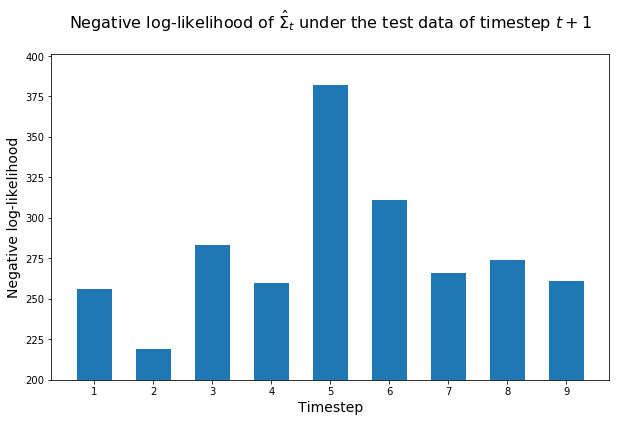

NLL = 279.183251551


In [576]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.figure(figsize=(10, 6))
plt.bar(range(1, nt), nll, width=0.6)
plt.ylim(200)
plt.title("Negative log-likelihood of $\hat{\Sigma}_t$ under the test data of timestep $t + 1$\n", fontsize=16)
plt.xlabel("Timestep", fontsize=14)
plt.ylabel("Negative log-likelihood", fontsize=14)
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [565]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 267.894728659


# Other methods of covariance estimation

## Diagonal

In [52]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

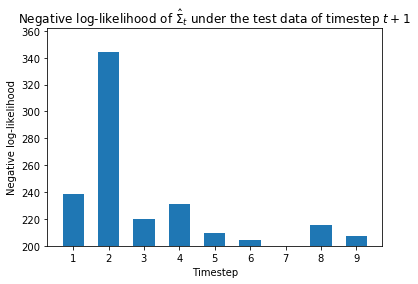

NLL = 230.007259762


In [53]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.bar(range(1, nt), nll, width=0.6)
plt.ylim(200)
plt.title("Negative log-likelihood of $\hat{\Sigma}_t$ under the test data of timestep $t + 1$")
plt.xlabel("Timestep")
plt.ylabel("Negative log-likelihood")
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [54]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 232.840175245


## Ledoit-Wolf Estimation

In [29]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

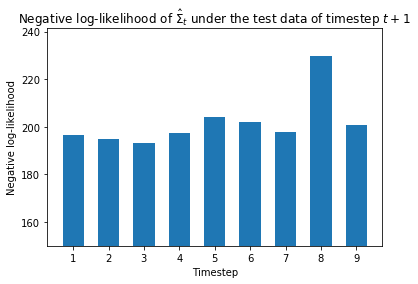

NLL = 201.792895704


In [30]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.bar(range(1, nt), nll, width=0.6)
plt.ylim(150)
plt.title("Negative log-likelihood of $\hat{\Sigma}_t$ under the test data of timestep $t + 1$")
plt.xlabel("Timestep")
plt.ylabel("Negative log-likelihood")
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [31]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 199.982100352


## Oracle Approximating Shrinkage

In [32]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

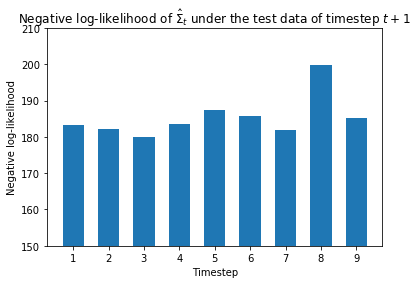

NLL = 185.453239263


In [33]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
#plt.plot(rangenll)
plt.bar(range(1, nt), nll, width=0.6)
plt.ylim(150)
plt.title("Negative log-likelihood of $\hat{\Sigma}_t$ under the test data of timestep $t + 1$")
plt.xlabel("Timestep")
plt.ylabel("Negative log-likelihood")
plt.xticks(range(1, nt))
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [34]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 184.091130684


## Graphical LASSO

In [5]:
covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars')
    glasso_est.fit(x)
    covs.append(glasso_est.covariance_)

OverflowError: long int too large to convert to float

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

In [ ]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [ ]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

# Summary of the results

1) Negative log-likelihood results:

| Model | NLL |  
|:------|----:|  
| ground truth                     |  35045.43 |  
| independent corexes              | 105237.22 |  
| regularized corex                |  61546.79 |  
| shrinkage estimator (coef = 0.1) | 162136.32 |
| Ledoit-Wolf                      | 52950.41  |
| OAS                              | 49325.46  |
| GLASSO                           | ill cond. |
| Emprical covariance              | ill cond. |

2) Without regularization the system doesn't detect the global change at the middle timestep, but with regularization it finds.